In [1]:
!pip install -r requirements-pube.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import PIL

In [3]:
PIL.__version__

'6.2.2'

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import numpy as np
import matplotlib.pyplot as plt

import os
import datetime
import json
import yaml
from collections import defaultdict, Counter
from copy import deepcopy
from importlib import reload
from collections import Counter

In [5]:
%matplotlib inline

In [6]:
F.one_hot

<function torch._C._nn.one_hot>

In [7]:
#Add synchronized directory
#Remember to keep up to date on the local machine 
distsup_dir = "/home/jovyan/Documents/DistSup"
import sys
sys.path.append(distsup_dir)

In [8]:
from distsup import reconstructors_analysis
from distsup.reconstructors_analysis.style_modeling.qmnist.dataset import get_dataset
from distsup.modules import pixcnn
from distsup.modules import quantizers

In [9]:
from distsup import utils
from distsup.modules import reconstructors, encoders, pixcnn
from distsup.models import vqvae, minitest, representation_learners
from distsup.data import PaddedDatasetLoader, FixedDatasetLoader, ChunkedDataset
from egs.mnist_seq.data import MNISTSequentialDataset

################################################################################
### WARNING, path does not exist: KALDI_ROOT=/mnt/matylda5/iveselyk/Tools/kaldi-trunk
###          (please add 'export KALDI_ROOT=<your_path>' in your $HOME/.profile)
###          (or run as: KALDI_ROOT=<your_path> python <your_script>.py)
################################################################################



In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
device

device(type='cuda')

## Classes

In [12]:
num_levels = 16

In [13]:
class MnistStyleModel(nn.Module):
    def __init__(self, activation=F.leaky_relu):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 16, kernel_size=3)
        self.dropout = nn.Dropout2d()
        self.activation = activation

    def forward(self, x):
        if len(x.shape) == 3:
            x = x[None, :]
        x = self.activation(F.max_pool2d(self.conv1(x), 2))
        x = self.dropout(x)
        x = self.activation(F.max_pool2d(self.conv2(x), 2))
        x = self.dropout(x)
        x = self.activation(self.conv3(x))
        return x.view(x.size(0), -1)

    @staticmethod
    def get_inputs(data, num_levels):
        x = data["images"].to(device)
        return (x * num_levels).clamp(0, num_levels - 1) / (num_levels - 1)

In [14]:
style_model = MnistStyleModel()

In [15]:
inps = torch.zeros((8,4,28,28))

In [16]:
style_vecs = torch.empty(8,4,144)
for i in range(4):
    style_vecs[:,i,:] = style_model(inps[:,i,:,:].unsqueeze(1))
style_vec = torch.mean(style_vecs, dim=1)

In [17]:
style_vec.shape

torch.Size([8, 144])

In [18]:
digit_cond = [{
    'cond_dim': 144,
    'reduction_factor': 0,
},
{
    'cond_dim': 10,
    'reduction_factor': 0,
}]

In [58]:
style_sizes = [1,2,4,8,16,32]

In [59]:
datasets = {i: get_dataset(i+1) for i in style_sizes}

In [60]:
train_loaders ={
    i: torch.utils.data.DataLoader(datasets[i][0], batch_size=64, num_workers=1, shuffle=True)   
    for i in style_sizes
}

In [61]:
test_loaders ={
    i: torch.utils.data.DataLoader(datasets[i][1], batch_size=64, num_workers=1, shuffle=False)   
    for i in style_sizes
}

In [62]:
models = {i: pixcnn.GatedPixelCNN(quantizer=dict(
                     class_name=quantizers.SoftmaxUniformQuantizer,
                     num_levels=num_levels
                     ),
                     cond_channels=digit_cond).to(device)
         for i in style_sizes}

In [63]:
style_models = {
    i: MnistStyleModel().to(device)
    for i in style_sizes
}

In [64]:
from distsup.reconstructors_analysis.style_modeling import trainer

In [65]:
trainers = {
    i: trainer.PixelCnnSingleAuthorStyleAveragingTrainer(
        models[i], 
        style_models[i], 
        train_loaders[i],
        test_data_loader=test_loaders[i],
        serialization_filename=f"PixelCNN_averaged_style_inputs_{i}",
        serialization_path="models/PixelCNN_averaged_style")
    for i in style_sizes
}

In [66]:
optims = {
    i: optim.Adam(models[i].parameters(), lr=1e-4)
    for i in style_sizes
}

In [67]:
style_optims = {
    i: optim.Adam(style_models[i].parameters(), lr=1e-4) 
    for i in style_models
}

In [29]:
num_epochs = 70

In [95]:
for i in style_sizes:
    print(f"Starting size {i} training")
    trainers[i].train(optims[i], style_optims[i], num_epochs)
    print("Serializing model")
    trainers[i].serialize(optims[i], style_optims[i])
    

Starting size 4 training
Train Epoch: 1 [0/28620 (0%)]	Loss: 143409.500000
Train Epoch: 1 [6400/28620 (22%)]	Loss: 74324.617188
Train Epoch: 1 [12800/28620 (45%)]	Loss: 47305.214844
Train Epoch: 1 [19200/28620 (67%)]	Loss: 42342.789062
Train Epoch: 1 [25600/28620 (89%)]	Loss: 41676.839844
Train Epoch: 2 [0/28620 (0%)]	Loss: 41418.753906
Train Epoch: 2 [6400/28620 (22%)]	Loss: 39462.945312
Train Epoch: 2 [12800/28620 (45%)]	Loss: 37621.742188
Train Epoch: 2 [19200/28620 (67%)]	Loss: 35001.054688
Train Epoch: 2 [25600/28620 (89%)]	Loss: 33101.265625
Train Epoch: 3 [0/28620 (0%)]	Loss: 29844.980469
Train Epoch: 3 [6400/28620 (22%)]	Loss: 29026.976562
Train Epoch: 3 [12800/28620 (45%)]	Loss: 25127.089844
Train Epoch: 3 [19200/28620 (67%)]	Loss: 24487.472656
Train Epoch: 3 [25600/28620 (89%)]	Loss: 23674.136719
Train Epoch: 4 [0/28620 (0%)]	Loss: 22095.312500
Train Epoch: 4 [6400/28620 (22%)]	Loss: 22869.048828
Train Epoch: 4 [12800/28620 (45%)]	Loss: 22523.640625
Train Epoch: 4 [19200/2862

In [130]:
optims = {
    i: optim.Adam(models[i].parameters(), lr=1e-3)
    for i in style_sizes
}

In [131]:
style_optims = {
    i: optim.Adam(style_models[i].parameters(), lr=1e-3) 
    for i in style_models
}

In [132]:
for i in style_sizes:
    print(f"Starting size {i} training")
    trainers[i].train(optims[i], style_optims[i], num_epochs)
    print("Serializing model")
    trainers[i].serialize(optims[i], style_optims[i])
    

Starting size 4 training
Train Epoch: 1 [0/28620 (0%)]	Loss: 13944.148438
Train Epoch: 1 [6400/28620 (22%)]	Loss: 14091.523438
Train Epoch: 1 [12800/28620 (45%)]	Loss: 15011.566406
Train Epoch: 1 [19200/28620 (67%)]	Loss: 14609.640625
Train Epoch: 1 [25600/28620 (89%)]	Loss: 14792.402344
Train Epoch: 2 [0/28620 (0%)]	Loss: 14410.322266
Train Epoch: 2 [6400/28620 (22%)]	Loss: 14858.560547
Train Epoch: 2 [12800/28620 (45%)]	Loss: 14934.812500
Train Epoch: 2 [19200/28620 (67%)]	Loss: 14566.027344
Train Epoch: 2 [25600/28620 (89%)]	Loss: 14415.777344
Train Epoch: 3 [0/28620 (0%)]	Loss: 13953.712891
Train Epoch: 3 [6400/28620 (22%)]	Loss: 13966.490234
Train Epoch: 3 [12800/28620 (45%)]	Loss: 14059.308594
Train Epoch: 3 [19200/28620 (67%)]	Loss: 14890.793945
Train Epoch: 3 [25600/28620 (89%)]	Loss: 14986.980469
Train Epoch: 4 [0/28620 (0%)]	Loss: 14725.767578
Train Epoch: 4 [6400/28620 (22%)]	Loss: 14575.064453
Train Epoch: 4 [12800/28620 (45%)]	Loss: 14231.478516
Train Epoch: 4 [19200/28620

In [32]:
optims = {
    i: optim.Adam(models[i].parameters(), lr=1e-4)
    for i in style_sizes
}

In [33]:
style_optims = {
    i: optim.Adam(style_models[i].parameters(), lr=1e-4) 
    for i in style_models
}

In [114]:
for i in style_sizes:
    print(f"Starting size {i} training")
    trainers[i].train(optims[i], style_optims[i], num_epochs)
    print("Serializing model")
    trainers[i].serialize(optims[i], style_optims[i])
    

Starting size 4 training
Train Epoch: 1 [0/28620 (0%)]	Loss: 14260.718750
Train Epoch: 1 [6400/28620 (22%)]	Loss: 13942.601562
Train Epoch: 1 [12800/28620 (45%)]	Loss: 14748.680664
Train Epoch: 1 [19200/28620 (67%)]	Loss: 14364.296875
Train Epoch: 1 [25600/28620 (89%)]	Loss: 14587.507812
Train Epoch: 2 [0/28620 (0%)]	Loss: 14692.357422
Train Epoch: 2 [6400/28620 (22%)]	Loss: 13980.561523
Train Epoch: 2 [12800/28620 (45%)]	Loss: 14499.944336
Train Epoch: 2 [19200/28620 (67%)]	Loss: 14482.299805
Train Epoch: 2 [25600/28620 (89%)]	Loss: 14461.410156
Train Epoch: 3 [0/28620 (0%)]	Loss: 14285.414062
Train Epoch: 3 [6400/28620 (22%)]	Loss: 13752.421875
Train Epoch: 3 [12800/28620 (45%)]	Loss: 14067.812500
Train Epoch: 3 [19200/28620 (67%)]	Loss: 14791.127930
Train Epoch: 3 [25600/28620 (89%)]	Loss: 15405.828125
Train Epoch: 4 [0/28620 (0%)]	Loss: 14417.986328
Train Epoch: 4 [6400/28620 (22%)]	Loss: 14384.968750
Train Epoch: 4 [12800/28620 (45%)]	Loss: 13813.264648
Train Epoch: 4 [19200/28620

In [35]:
rec_losses = {
    i: [r.mean().item() for r in trainers[i].recon_losses]
    for i in style_sizes
}

In [57]:
for i, r in rec_losses.items():
    print(i, r[-1], len(r))

1 0.27070730924606323 210
2 0.26505473256111145 210
4 0.2647022604942322 210
8 0.2640857398509979 210
16 0.27070730924606323 210
32 0.27097171545028687 210


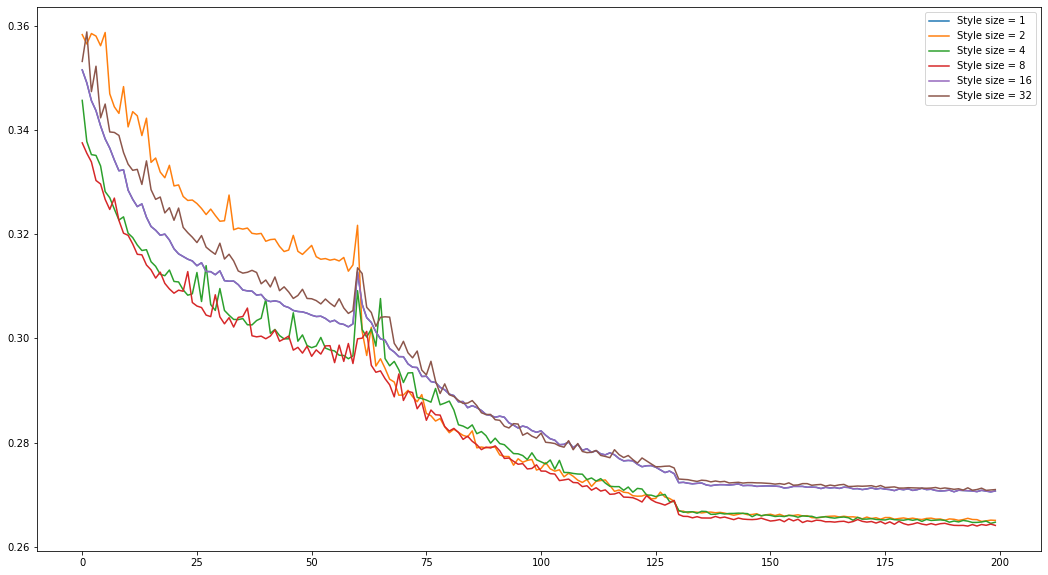

In [58]:
fig = plt.figure(figsize=(18,10))
for s in style_sizes:
    plt.plot(np.arange(len(rec_losses[s]) - 10), rec_losses[s][10:], label=f"Style size = {s}")
plt.legend()

In [59]:
for size in style_sizes:
    models[size].eval()
    style_models[size].eval()
    recs = trainers[size].test_model_reconstruction(2500)
    print(size, recs.mean().item())

1 0.27424415946006775
2 0.2693398892879486
4 0.26865461468696594
8 0.2681109607219696
16 0.26712703704833984
32 0.2670288681983948


In [56]:
def plot_models_samples(num_samples=10):
    fig, axs = plt.subplots(num_samples, len(style_sizes), figsize=(10,18))
    for digit in range(num_samples):
        author_id = np.random.randint(0, 5000)
        print(f"Digit {digit} author ID: {author_id}")
        for i, trainer in enumerate(list(trainers.values())):
            data = trainer.test_data_loader.dataset[author_id]
            sample = trainer.sample(data, digit)
            axs[digit].imshow(sample.data.cpu().view(28, 28), cmap='gray')
    plt.show()

Digit 0 author ID: 1324
Digit 1 author ID: 2327
Digit 2 author ID: 2399
Digit 3 author ID: 1967
Digit 4 author ID: 327
Digit 5 author ID: 4208
Digit 6 author ID: 1346
Digit 7 author ID: 3281
Digit 8 author ID: 4451
Digit 9 author ID: 698


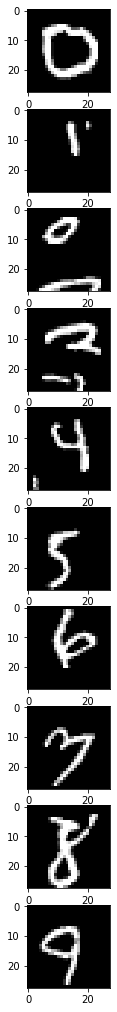

In [41]:
plot_models_samples(10)

In [68]:
models_path = "models/PixelCNN_averaged_style"
model_file_tpl = "PixelCNN_averaged_style_inputs_{}"

In [69]:
models_files = os.listdir(models_path)

In [70]:
training_iter = 2

In [32]:
[file for file in models_files if file.startswith(model_file_tpl.format(8))]

['PixelCNN_averaged_style_inputs_8GatedPixelCNN_2020-07-26_17:37:53.pkl',
 'PixelCNN_averaged_style_inputs_8GatedPixelCNN_2020-07-27_03:56:46.pkl',
 'PixelCNN_averaged_style_inputs_8GatedPixelCNN_2020-07-26_22:56:32.pkl']

In [71]:
for size in style_sizes:
    model_files = [file for file in models_files if file.startswith(model_file_tpl.format(size))]
    model_files.sort()
    model_filepath = os.path.join(models_path, model_files[training_iter])
    checkpoint = torch.load(model_filepath)
    models[size].load_state_dict(checkpoint['model_state_dict'])
    style_models[size].load_state_dict(checkpoint['style_model_state_dict'])
    optims[size].load_state_dict(checkpoint['optimizer_model'])
    style_optims[size].load_state_dict(checkpoint['optimizer_style'])
    trainers[size].recon_losses = checkpoint['recon_losses']

In [35]:
test_data = {}
for size in style_sizes:
    print(f"Testing size {size}")
    test_data[size] = trainers[size].test_model_classification(2500)

  0%|          | 1/2500 [00:00<04:32,  9.18it/s]

Testing size 1


  0%|          | 1/2500 [00:00<04:30,  9.23it/s]

Testing size 2


  0%|          | 1/2500 [00:00<04:44,  8.77it/s]

Testing size 4


100%|██████████| 2500/2500 [07:56<00:00,  5.25it/s]


In [36]:
#test
for i, res in test_data.items():
    print(i, sum([t["correct"] for t in res]) / len(res))

1 0.97
2 0.9796
4 0.9812
8 0.9808
16 0.9828
32 0.984


In [ ]:
tests = 5
for t in range(tests):
    print(f"Test {t}")
    print("True author testing")
    test_data = {}
    for size in style_sizes:
        test_data[size] = trainers[size].test_model_classification(2500)
    for i, res in test_data.items():
        print(i, sum([t["correct"] for t in res]) / len(res))
    
    print("Fake author testing")
    test_data_fake_authors = {}
    for size in style_sizes:
        test_data_fake_authors[size] = trainers[size].test_model_classification(2500, fake_authors=True)
    for i, res in test_data_fake_authors.items():
        print(i, sum([t["correct"] for t in res]) / len(res))

Test 0
True author testing
4 0.9776
Fake author testing
4 0.9156
Test 1
True author testing
4 0.9836
Fake author testing


## Train set reconstruction

In [26]:
trainers = {
    i: trainer.PixelCnnSingleAuthorStyleAveragingTrainer(
        models[i], 
        style_models[i], 
        train_loaders[i],
        test_data_loader=train_loaders[i],
        serialization_filename=f"PixelCNN_averaged_style_inputs_{i}",
        serialization_path="models/PixelCNN_averaged_style")
    for i in style_sizes
}

In [36]:
for i, r in rec_losses.items():
    print(i, r[-1], len(r))

1 0.27070730924606323 210
2 0.26505473256111145 210
4 0.2647022604942322 210
8 0.2640857398509979 210
16 0.27070730924606323 210
32 0.27097171545028687 210


In [37]:
#TRAIN SET RECONSTRUCTION
for size in style_sizes:
    trainers[size].eval_mode()
    recs = trainers[size].test_model_reconstruction(10000)
    print(size, recs.mean().item())

1 0.28891322016716003
2 0.28361618518829346
4 0.28208306431770325
8 0.2826460003852844
16 0.2816072702407837
32 0.28041258454322815
